## Stable Diffusion fine tune with DreamBooth on SageMaker notebook
* Tested with ml.g5.2xlarge SageMaker notebook, which has a NVIDIA A10G GPU with 24 GiB GPU memory.
* If you tend to use a GPU with less memory e.g. NVIDIA T4 with 16 GiB GPU memory, pls refer to [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)

### 1. Install dependencies

In [1]:
!pip install -U pip
!pip install -U torch==1.13.1+cu117 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/huggingface/diffusers.git

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-fu4lj1pa
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-fu4lj1pa
  Resolved https://github.com/huggingface/diffusers.git to commit 8c14ca3d434c1ff5b118f0b18e1db20fea73c51f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
%%writefile requirements.txt
accelerate
torchvision
transformers>=4.25.1
ftfy
tensorboard
modelcards
bitsandbytes==0.35.4  # newly updated version of bitsandbytes made images garbage, so fix the version
datasets  # huggingface diffusers bug for missing implementation of datasets

Writing requirements.txt


In [3]:
!pip install -U -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


### 2. Initialize an Accelerate environment 

In [4]:
from accelerate.utils import write_basic_config
write_basic_config()

Configuration already exists at /home/ec2-user/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

### 3. Get training scripts from HuggingFace Diffusers

In [5]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

### 4. Train a modle for generating a person in cyberpunk style  
* "style" training example, you can also train the model for "object" or "person"  
* More information you can refer to [DreamBooth example of Huggingface Diffusers](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth)

In [6]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "stable_diffusion_weights/dreambooth_fine_tune"
INSTANCE_DATA_DIR = "images/source"
CLASS_DATA_DIR = "images/class"
!mkdir -p $OUTPUT_DIR $INSTANCE_DATA_DIR $CLASS_DATA_DIR

In [7]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/source/* $INSTANCE_DATA_DIR
# you can generate your own class images during training
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/class/* $CLASS_DATA_DIR 

Cloning into 'stablediffusion-dreambooth-training-example'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 236 (delta 9), reused 226 (delta 5), pack-reused 0
Receiving objects: 100% (236/236), 12.32 MiB | 58.70 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [8]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --train_text_encoder \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="a photo of cypk style" \
  --class_prompt="a photo of style" \
  --resolution=512 \
  --train_batch_size=1 \
  --use_8bit_adam \
  --gradient_checkpointing \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=1000

01/02/2023 15:55:56 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'prediction_type'} was not found in config. Values will be initialized to default values.
{'upcast_attention', 'resnet_time_scale_shift', 'use_linear_projection', 'dual_cross_attention', 'class_embed_type', 'num_class_embeds', 'only_cross_attention', 'mid_block_type'} was not found in config. Values will be initialized to default values.
01/02/2023 15:56:01 - INFO - __main__ - ***** Running training *****
01/02/2023 15:56:01 - INFO - __main__ -   Num examples = 200
01/02/2023 15:56:01 - INFO - __main__ -   Num batches each epoch = 200
01/02/2023 15:56:01 - INFO - __main__ -   Num Epochs = 5
01/02/2023 15:56:01 - INFO - __main__ -   Instantaneous batch si

### 5. Mode inference testing

  0%|          | 0/20 [00:00<?, ?it/s]

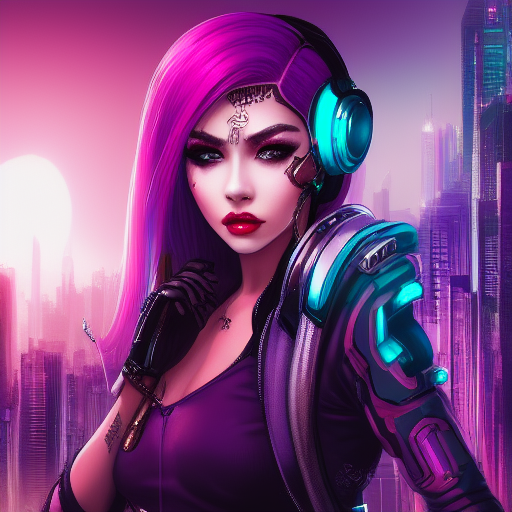

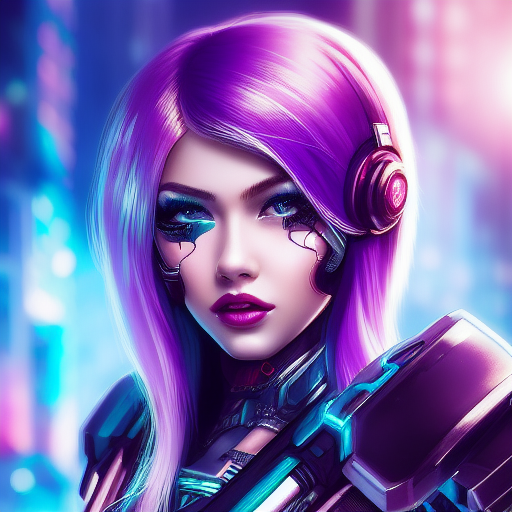

In [9]:
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
model_dir = OUTPUT_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
prompt = "a photo cypk style girl, pretty detailed face, city background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"
generated_images = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=2,
    num_inference_steps=20,
    guidance_scale=7.5
).images
for image in generated_images:
    display(image)

### 6. Use scripts to convert weights to ckpt to use in web UIs like AUTOMATIC1111

In [10]:
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_diffusers_to_original_stable_diffusion.py
ckpt_path = OUTPUT_DIR + "/model.ckpt"
half_arg = ""
# Whether to convert to fp16, takes half the space (2GB).
fp16 = False # {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at stable_diffusion_weights/dreambooth_fine_tune/model.ckpt
